In [2]:
# Basic Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import shap
import random

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torch.cuda.amp import autocast, GradScaler

# Torchvision
from torchvision import transforms, datasets, utils
from torchvision.transforms.functional import to_pil_image

# Scattering Transform
from kymatio.torch import Scattering2D

# Captum for XAI
from captum.attr import Saliency, ShapleyValueSampling

# Sklearn Utilities
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

import cv2


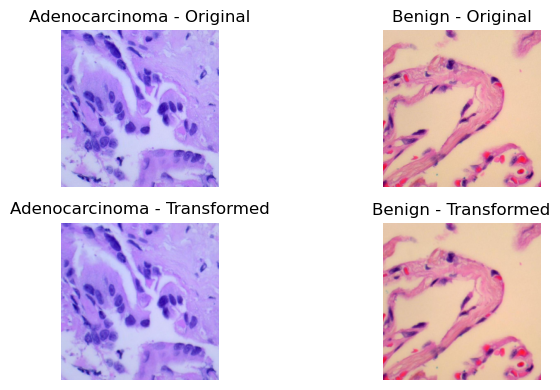

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
IMG_SIZE = 224

# Define paths for training and testing
adenocarcinoma_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma"
benign_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/benign"

# Transformation pipeline for RGB images
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # for 3 channels
])

# Show one image from each dataset before and after transformation
def show_sample_images():
    adenocarcinoma_files = os.listdir(adenocarcinoma_path)
    benign_files = os.listdir(benign_path)

    # Load one image from each class without transformation
    adenocarcinoma_img = Image.open(os.path.join(adenocarcinoma_path, adenocarcinoma_files[0])).convert("RGB")
    benign_img = Image.open(os.path.join(benign_path, benign_files[0])).convert("RGB")

    # Apply transformation
    adenocarcinoma_img_transformed = transform(adenocarcinoma_img)
    benign_img_transformed = transform(benign_img)

    # Convert tensors back to numpy images for visualization
    def tensor_to_image(tensor):
        img = tensor.permute(1, 2, 0).numpy()  # CHW -> HWC
        img = (img * 0.5) + 0.5  # unnormalize
        return np.clip(img, 0, 1)

    # Plot original and transformed images
    plt.figure(figsize=(8, 4))
    plt.subplot(2, 2, 1)
    plt.title("Adenocarcinoma - Original")
    plt.imshow(adenocarcinoma_img)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Benign - Original")
    plt.imshow(benign_img)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Adenocarcinoma - Transformed")
    plt.imshow(tensor_to_image(adenocarcinoma_img_transformed))
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Benign - Transformed")
    plt.imshow(tensor_to_image(benign_img_transformed))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images()


In [4]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and convert to RGB
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [5]:
# Step 1: Load full image paths and labels
image_paths = []
labels = []

for filename in os.listdir(adenocarcinoma_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(os.path.join(adenocarcinoma_path, filename))
        labels.append(1)

for filename in os.listdir(benign_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(os.path.join(benign_path, filename))
        labels.append(0)

print(f"Total images loaded: {len(image_paths)}")

# Step 2: Hold out a test set (20%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 3: Create datasets
train_dataset_full = CustomDataset(train_paths, train_labels, transform)  # used for K-Fold
test_dataset = CustomDataset(test_paths, test_labels, transform)          # final hold-out

# Step 4: Final test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Sanity check
print(f"Train samples: {len(train_dataset_full)}")
print(f"Test samples (held-out): {len(test_dataset)}")

Total images loaded: 10000
Train samples: 8000
Test samples (held-out): 2000


In [6]:
class ImprovedCNN(nn.Module):
    def __init__(self, img_size=224, in_channels=3):
        super(ImprovedCNN, self).__init__()

        # --- Convolutional Blocks ---
        self.conv1 = nn.Conv2d(in_channels,16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        # --- Adaptive Pooling to reduce hardcoding size ---
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output: [batch, 128, 1, 1]
        
        # --- Fully Connected Layers ---
        self.classifier = nn.Sequential(
            nn.Flatten(),               # [batch, 128 * 1 * 1] = [batch, 128]
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [7]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ImprovedCNN()
model

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")



Using device: mps


In [9]:
from collections import Counter
print("Train set class distribution:", Counter(train_labels))
print("Test set class distribution:", Counter(test_labels))


Train set class distribution: Counter({0: 4000, 1: 4000})
Test set class distribution: Counter({0: 1000, 1: 1000})


In [66]:
# ---- Config ----
k = 5
max_epochs = 10
batch_size = 64
lr = 0.0005
weight_decay = 1e-3

# ---- Tracking Lists ----
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_accuracies': [], 'val_accuracies': [],
    'fold_accuracies': [], 'fold_f1s': []
}

best_f1, best_model_state = 0.0, None

# ---- Helper Functions ----
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []

    with torch.set_grad_enabled(is_train):
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item() * X.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_targets

# ---- Cross-Validation ----
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
indices = np.arange(len(train_dataset_full))
labels = np.array(train_labels)

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f"\n========== Fold {fold + 1}/{k} ==========")

    train_loader = DataLoader(Subset(train_dataset_full, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(Subset(train_dataset_full, val_idx), batch_size=batch_size, shuffle=False)

    model = ImprovedCNN().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    fold_train_losses, fold_val_losses = [], []
    fold_train_accs, fold_val_accs = [], []

    for epoch in range(max_epochs):
        train_loss, train_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_preds, val_targets = run_epoch(model, val_loader, criterion)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accs.append(train_acc)
        fold_val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    f1 = f1_score(val_targets, val_preds, average='weighted')
    acc = accuracy_score(val_targets, val_preds)

    metrics['fold_accuracies'].append(acc)
    metrics['fold_f1s'].append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict().copy()
        print(f"New best model updated! F1: {f1:.4f}")

    metrics['train_losses'].append(fold_train_losses)
    metrics['val_losses'].append(fold_val_losses)
    metrics['train_accuracies'].append(fold_train_accs)
    metrics['val_accuracies'].append(fold_val_accs)

# ---- Save Best Model ----
torch.save(best_model_state, "best_cnn_model.pth")
print("\nBest model saved to 'best_cnn_model.pth'.")

# ---- Summary ----
print("\n========== K-FOLD SUMMARY ==========")
for i, (acc, f1) in enumerate(zip(metrics['fold_accuracies'], metrics['fold_f1s'])):
    print(f"Fold {i+1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

print(f"\nMean Accuracy: {np.mean(metrics['fold_accuracies']):.4f}")
print(f"Mean F1 Score: {np.mean(metrics['fold_f1s']):.4f}")
print(f"Best F1 Score: {best_f1:.4f}")



========== Fold 1/5 ==========
Epoch 1: Train Loss=0.1227, Val Loss=0.0184, Train Acc=0.9697, Val Acc=0.9938
Epoch 2: Train Loss=0.0248, Val Loss=0.0527, Train Acc=0.9922, Val Acc=0.9756
Epoch 3: Train Loss=0.0140, Val Loss=0.0197, Train Acc=0.9966, Val Acc=0.9944
Epoch 4: Train Loss=0.0123, Val Loss=0.0190, Train Acc=0.9958, Val Acc=0.9944
Epoch 5: Train Loss=0.0119, Val Loss=0.0086, Train Acc=0.9953, Val Acc=0.9969
Epoch 6: Train Loss=0.0069, Val Loss=0.0116, Train Acc=0.9977, Val Acc=0.9956
Epoch 7: Train Loss=0.0079, Val Loss=0.0037, Train Acc=0.9973, Val Acc=0.9981
Epoch 8: Train Loss=0.0051, Val Loss=0.0094, Train Acc=0.9983, Val Acc=0.9975
Epoch 9: Train Loss=0.0060, Val Loss=0.0033, Train Acc=0.9977, Val Acc=0.9981
Epoch 10: Train Loss=0.0023, Val Loss=0.0082, Train Acc=0.9998, Val Acc=0.9981
New best model updated! F1: 0.9981

========== Fold 2/5 ==========
Epoch 1: Train Loss=0.1144, Val Loss=0.0247, Train Acc=0.9730, Val Acc=0.9956
Epoch 2: Train Loss=0.0230, Val Loss=0.008

In [67]:
def plot_foldwise_metrics(train_losses, val_losses, train_accs, val_accs):
    num_folds = len(train_losses)

    for i in range(num_folds):
        epochs = range(1, len(train_losses[i]) + 1)

        plt.figure(figsize=(10, 4))

        # ---- Subplot 1: Loss ----
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses[i], label='Train Loss')
        plt.plot(epochs, val_losses[i], label='Val Loss', linestyle='--')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {i+1} - Loss")
        plt.legend()

        # ---- Subplot 2: Accuracy ----
        plt.subplot(1, 2, 2)
        plt.plot(epochs, [acc * 100 for acc in train_accs[i]], label='Train Accuracy')
        plt.plot(epochs, [acc * 100 for acc in val_accs[i]], label='Val Accuracy', linestyle='--')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Fold {i+1} - Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


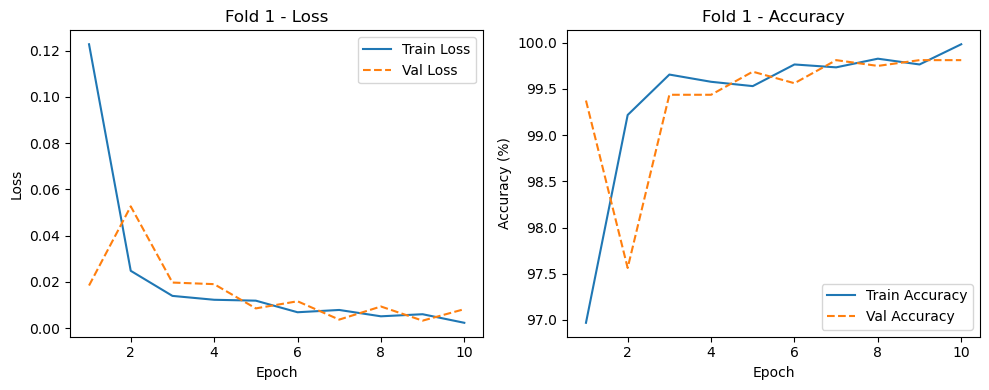

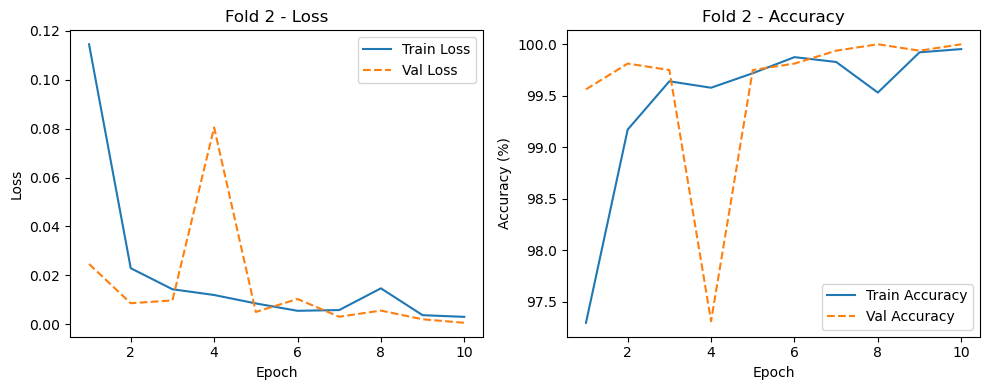

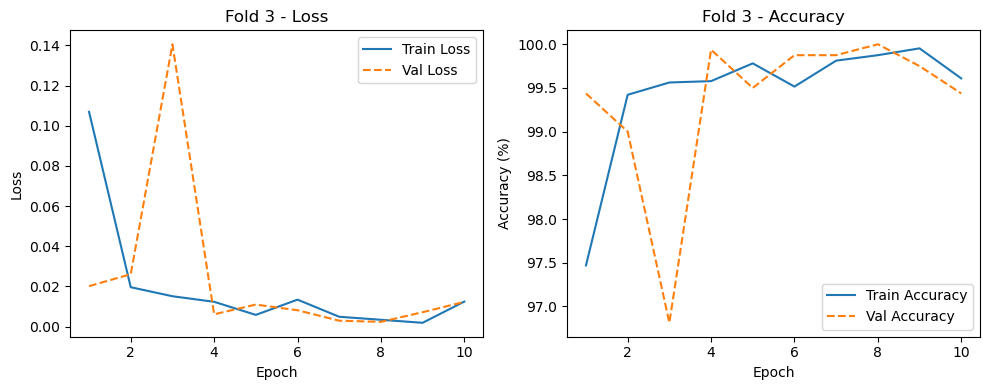

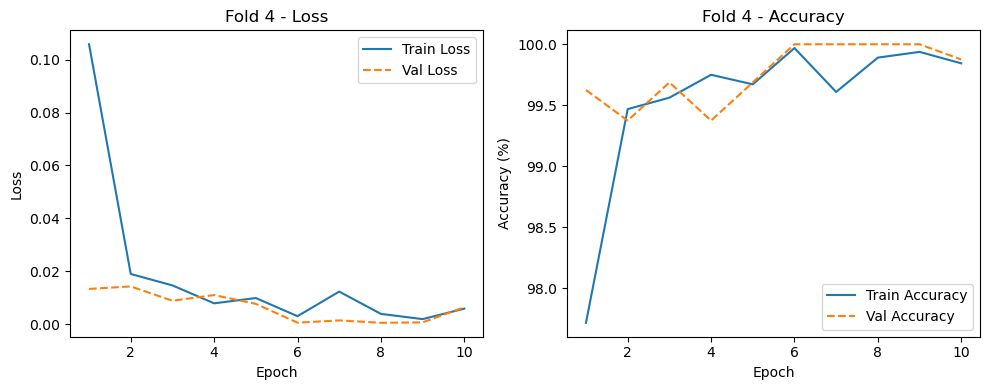

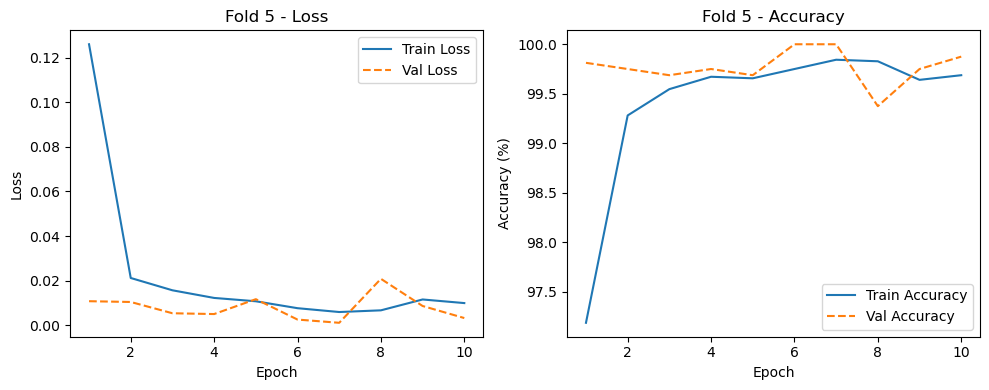

In [68]:
# ---- Plot Foldwise Metrics ----
plot_foldwise_metrics(
    metrics['train_losses'],
    metrics['val_losses'],
    metrics['train_accuracies'],
    metrics['val_accuracies']
)


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_41307/1115364350.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_mo

Loaded best model from K-Fold.


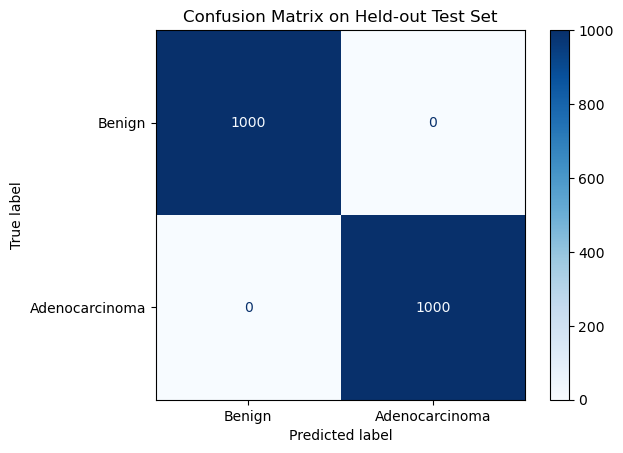


Classification Report:
                precision    recall  f1-score   support

        Benign       1.00      1.00      1.00      1000
Adenocarcinoma       1.00      1.00      1.00      1000

      accuracy                           1.00      2000
     macro avg       1.00      1.00      1.00      2000
  weighted avg       1.00      1.00      1.00      2000



In [9]:
# Load best model saved during K-Fold
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.eval()
print("Loaded best model from K-Fold.")

# Inference on the hold-out test set
all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        outputs = model(X_test)
        predicted = torch.argmax(outputs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Adenocarcinoma'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Held-out Test Set")
plt.show()

# Optional: print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Adenocarcinoma']))


In [56]:
def visualize_all_conv_outputs(image_tensor, label_name):
    # Expecting image_tensor shape: [3, 64, 64]
    x = image_tensor.unsqueeze(0).to(device)  # shape: [1, 3, 64, 64]

    model.eval()
    outputs = []
    names = []

    # Forward through conv layers
    x = model.pool(F.relu(model.bn1(model.conv1(x))))
    outputs.append(x)
    names.append("Conv1")

    x = model.pool(F.relu(model.bn2(model.conv2(x))))
    outputs.append(x)
    names.append("Conv2")

    x = model.pool(F.relu(model.bn3(model.conv3(x))))
    outputs.append(x)
    names.append("Conv3")

    # Show original RGB image
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
    img_np = (img_np * 0.5) + 0.5  # Unnormalize (if normalized to [-1, 1])
    img_np = img_np.clip(0, 1)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_np)
    plt.title(f"Original Image - {label_name}")
    plt.axis("off")
    plt.show()

    # Plot each conv layer output
    for idx, feature_map in enumerate(outputs):
        feature_map = feature_map.squeeze(0)  # shape: [C, H, W]
        num_filters = feature_map.shape[0]
        cols = 8
        rows = (num_filters + cols - 1) // cols

        fig = plt.figure(figsize=(15, rows * 2))
        for i in range(num_filters):
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.imshow(feature_map[i].cpu().detach().numpy(), cmap='viridis')
            ax.axis('off')
            ax.set_title(f'{i}', fontsize=6)

        plt.suptitle(f"{names[idx]} Output: {num_filters} Filters", fontsize=16)
        plt.tight_layout()
        plt.show()


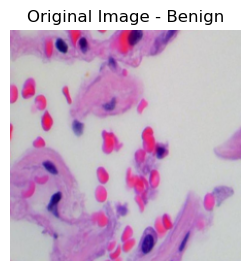

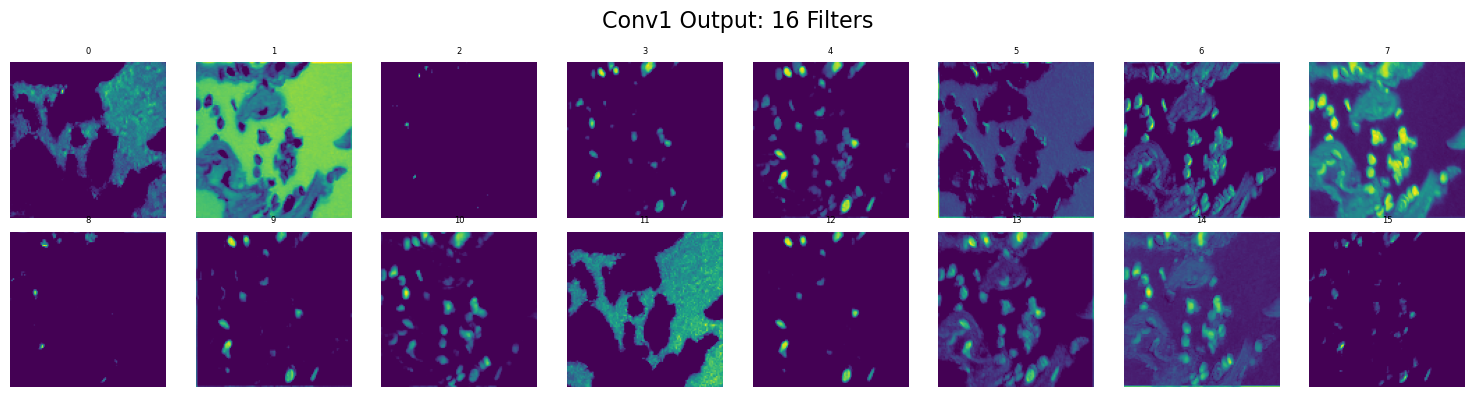

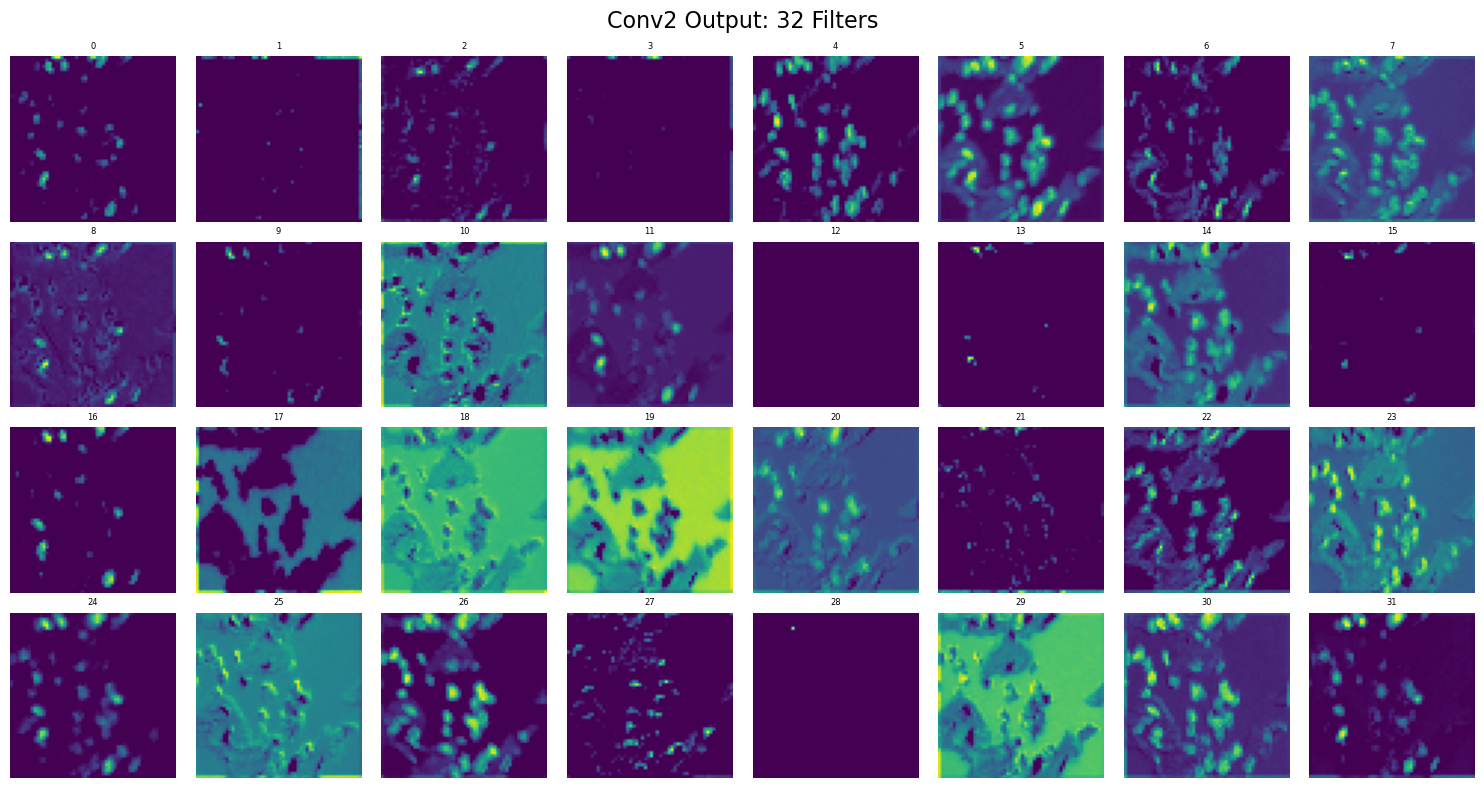

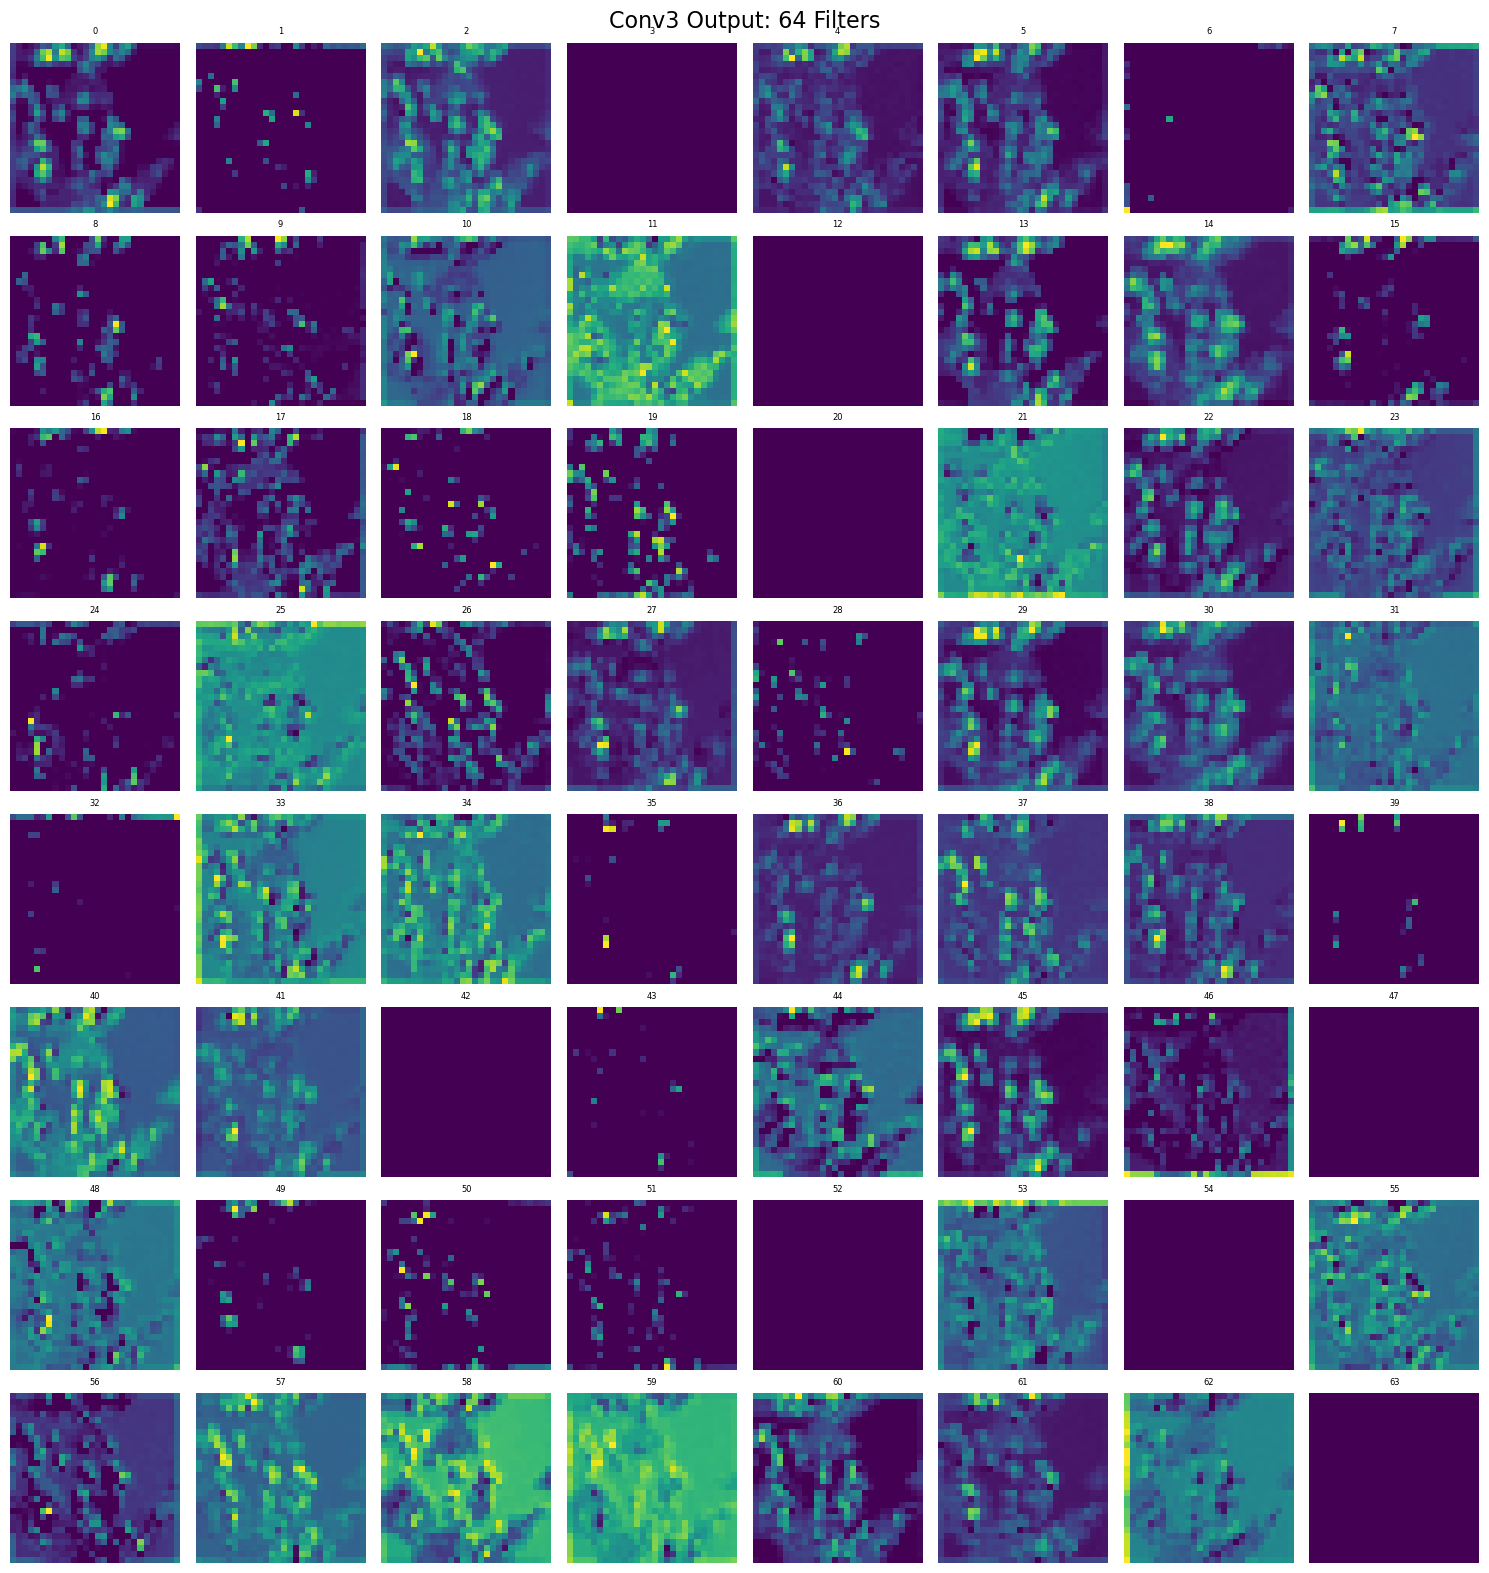

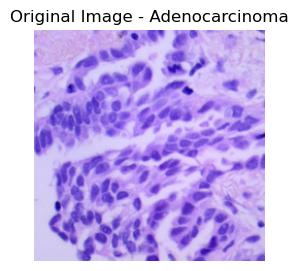

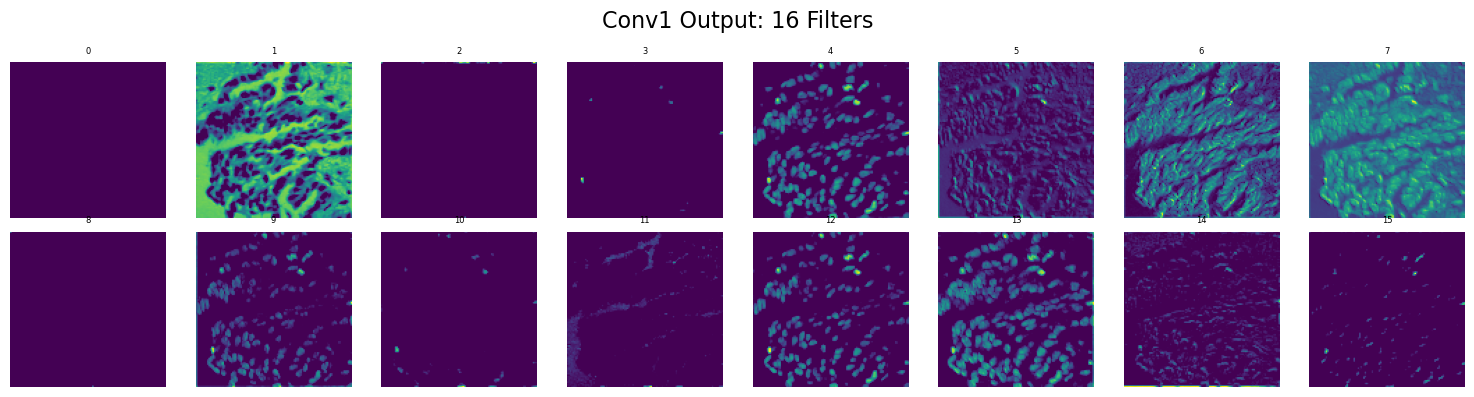

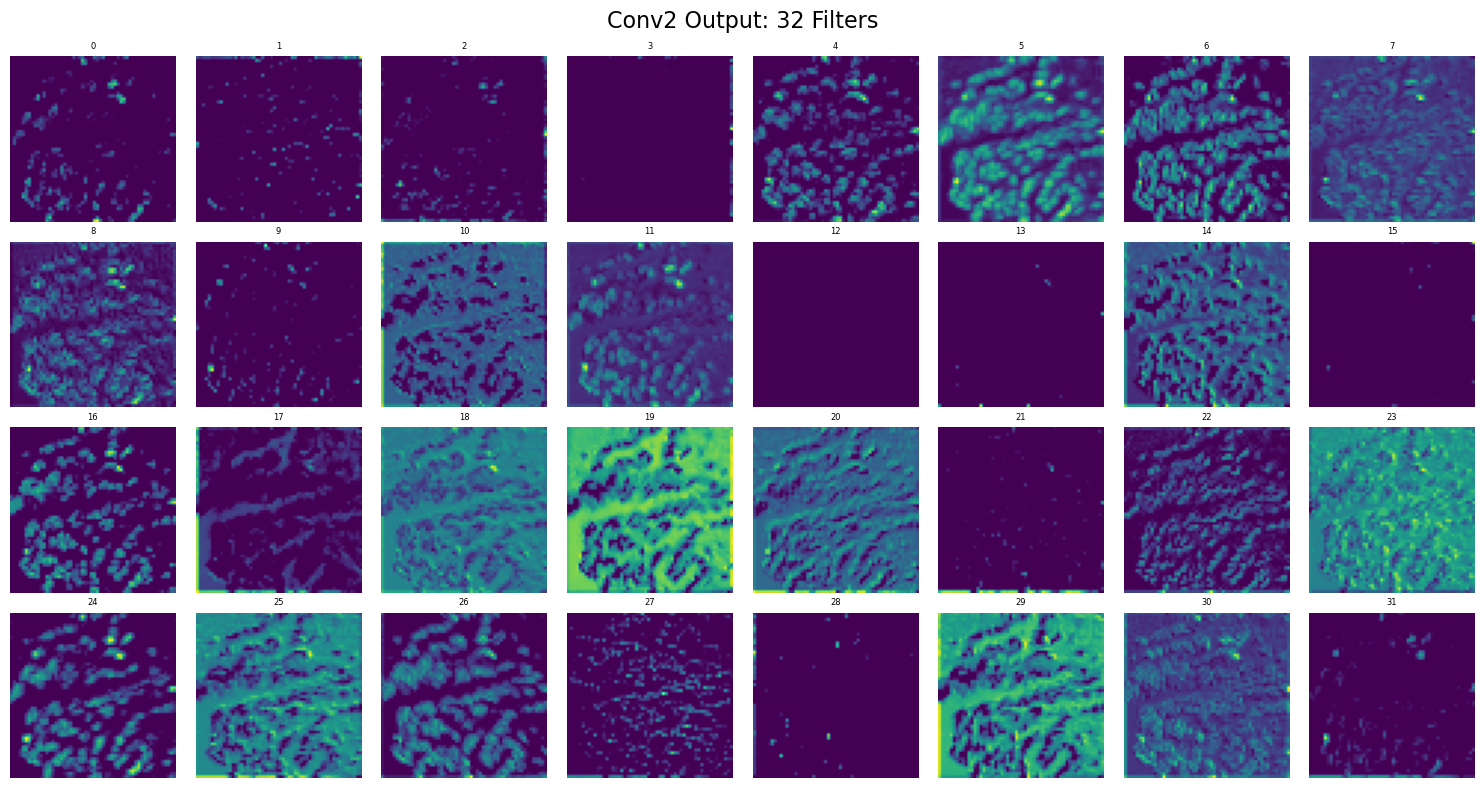

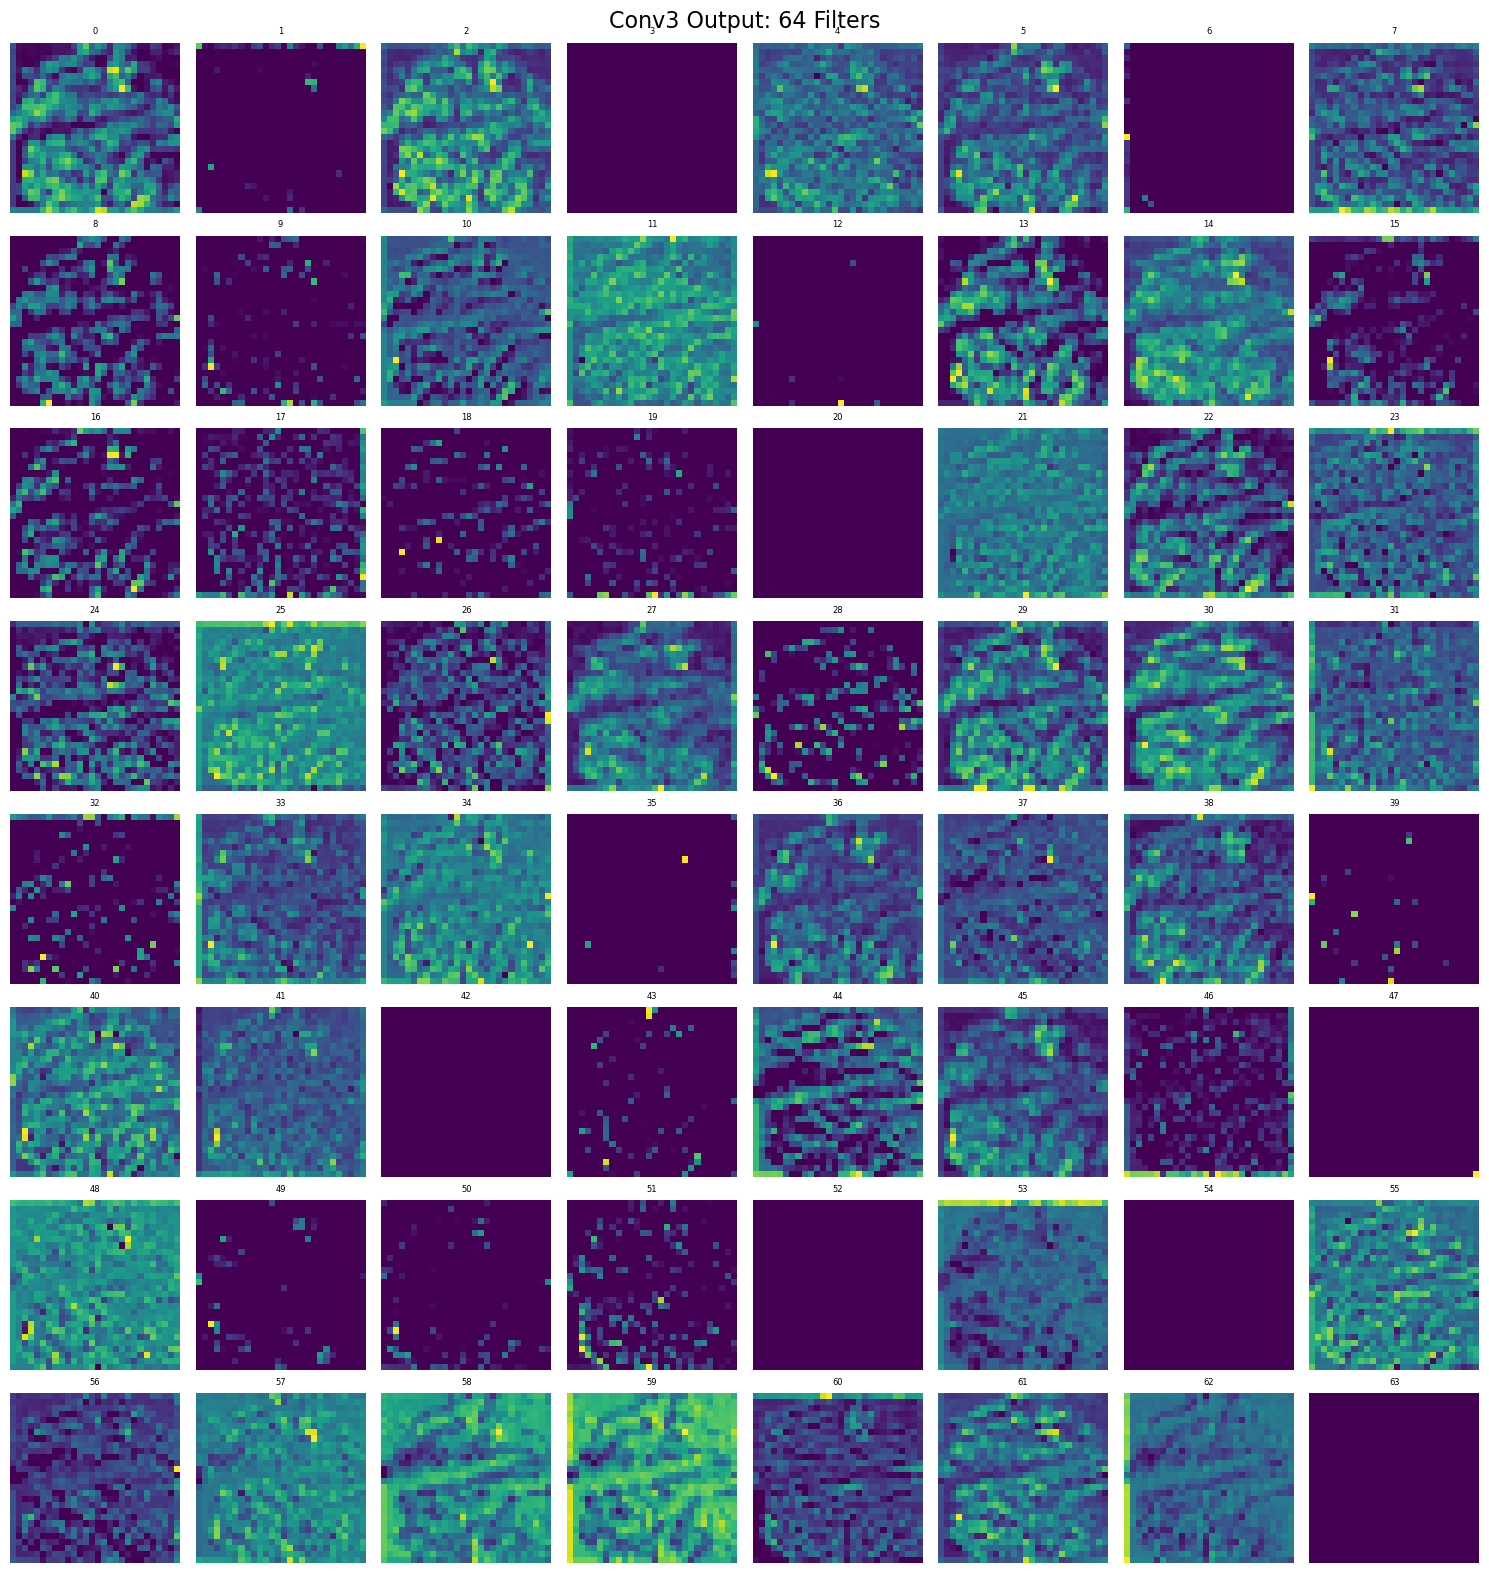

In [57]:
# Visualize one benign image
for img, label in train_dataset_full:
    if label == 0:
        visualize_all_conv_outputs(img, "Benign")
        break

# Visualize one adenocarcinoma image
for img, label in train_dataset_full:
    if label == 1:
        visualize_all_conv_outputs(img, "Adenocarcinoma")
        break


In [9]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define paths for training and testing
adenocarcinoma_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma"
benign_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/benign"



# Define MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create scattering object
IMG_SIZE = 64
J = 2
L = 8
scattering = Scattering2D(J=J, shape=(IMG_SIZE, IMG_SIZE), L=L).to(device)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Custom Dataset
class ScatteringDataset(Dataset):
    def __init__(self, image_paths, labels, scattering, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.scattering = scattering
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and apply transform
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)  # [1, 64, 64]

        img = img.to(torch.float32).to(self.device)


        with torch.no_grad():
            Sx = self.scattering(img.unsqueeze(0))  # [1, 81, 16, 16]
            Sx = Sx.squeeze()


        return Sx, label

In [10]:

scattering_dataset = ScatteringDataset(train_paths, train_labels, scattering, transform=transform, device=device)

# Test it
X, y = scattering_dataset[0]
print("Returned shape:", X.shape)
print("Label:", y)

Returned shape: torch.Size([81, 16, 16])
Label: 0


In [11]:

class ScatNetClassifier(nn.Module):
    def __init__(self, input_dim=81):
        super(ScatNetClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):

        return self.classifier(x)


In [137]:
# ---- Config ----
k = 5
epochs = 10
batch_size = 64

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
indices = np.arange(len(train_paths))
labels_np = np.array(train_labels)

fold_accuracies, fold_f1s = [], []
train_losses_per_epoch, val_losses_per_epoch = [], []
train_accs_per_epoch, val_accs_per_epoch = [], []

# ---- Use only mean pooled features: size [81] ----
input_dim = 81
model_class = ScatNetClassifier(input_dim=input_dim)

# ---- Track best model across all folds ----
best_val_f1 = 0.0
best_model_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels_np)):
    print(f"\n--- Fold {fold+1} ---")

    train_subset = Subset(scattering_dataset, train_idx)
    val_subset = Subset(scattering_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # New model per fold
    model = ScatNetClassifier(input_dim=input_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Average pooling over spatial dims
            X_batch = X_batch.mean(dim=(-1, -2))  # [batch_size, 81]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                X_batch = X_batch.mean(dim=(-1, -2))  # [batch_size, 81]

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(1) == y_batch).sum().item()
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_subset)
        val_acc = val_correct / len(val_subset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # ---- Save best model (highest F1 score) ----
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()
            print("Best model updated.")

    fold_accuracies.append(val_acc)
    fold_f1s.append(val_f1)
    train_losses_per_epoch.append(train_losses)
    val_losses_per_epoch.append(val_losses)
    train_accs_per_epoch.append(train_accs)
    val_accs_per_epoch.append(val_accs)

# ---- Summary ----
print(f"\nMean Accuracy across {k} folds: {np.mean(fold_accuracies):.4f}")
print(f"Mean F1 Score across {k} folds: {np.mean(fold_f1s):.4f}")

# ---- Save best model ----
if best_model_state is not None:
    torch.save(best_model_state, "best_scatnet_model.pth")
    print("Best model saved to 'best_scatnet_model.pth'")



--- Fold 1 ---
Epoch 1/10 - Train Loss: 0.6128, Train Acc: 0.7273 | Val Loss: 0.4408, Val Acc: 0.8594, Val F1: 0.8588
Best model updated.
Epoch 2/10 - Train Loss: 0.3971, Train Acc: 0.8406 | Val Loss: 0.3420, Val Acc: 0.8606, Val F1: 0.8605
Best model updated.
Epoch 3/10 - Train Loss: 0.3544, Train Acc: 0.8530 | Val Loss: 0.3196, Val Acc: 0.8731, Val F1: 0.8722
Best model updated.
Epoch 4/10 - Train Loss: 0.3385, Train Acc: 0.8598 | Val Loss: 0.3102, Val Acc: 0.8769, Val F1: 0.8758
Best model updated.
Epoch 5/10 - Train Loss: 0.3300, Train Acc: 0.8652 | Val Loss: 0.3037, Val Acc: 0.8812, Val F1: 0.8812
Best model updated.
Epoch 6/10 - Train Loss: 0.3218, Train Acc: 0.8691 | Val Loss: 0.2892, Val Acc: 0.8844, Val F1: 0.8836
Best model updated.
Epoch 7/10 - Train Loss: 0.3142, Train Acc: 0.8747 | Val Loss: 0.2824, Val Acc: 0.8912, Val F1: 0.8907
Best model updated.
Epoch 8/10 - Train Loss: 0.3128, Train Acc: 0.8756 | Val Loss: 0.2734, Val Acc: 0.8931, Val F1: 0.8928
Best model updated.


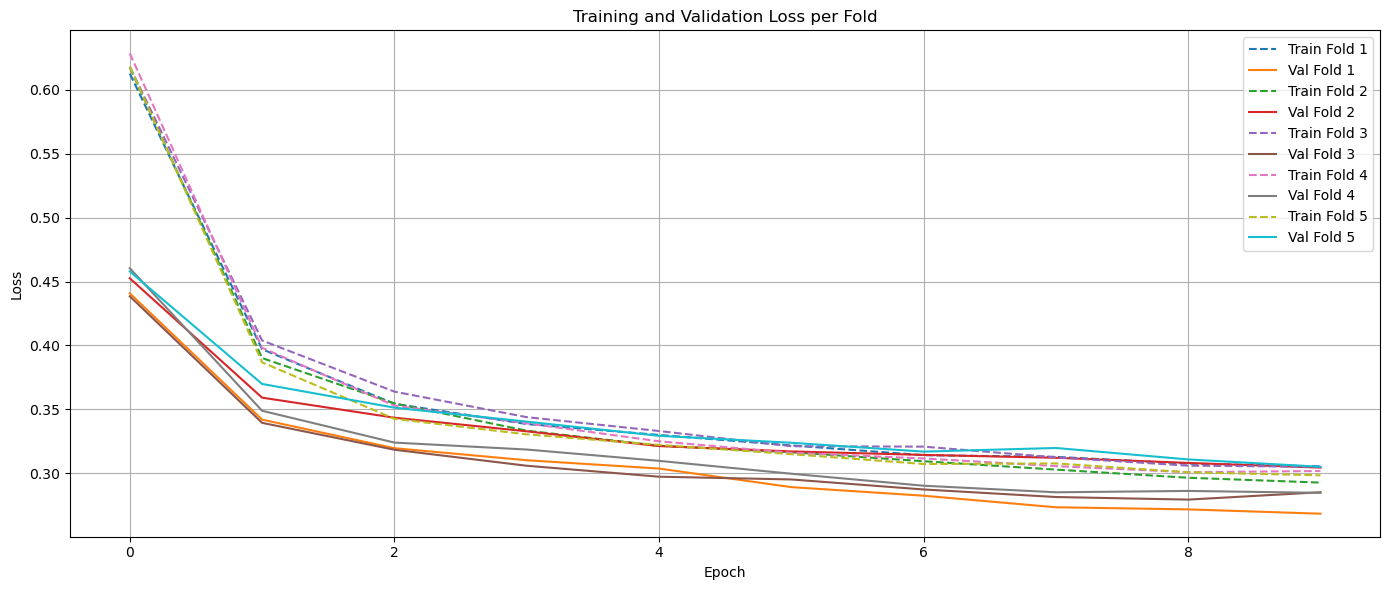

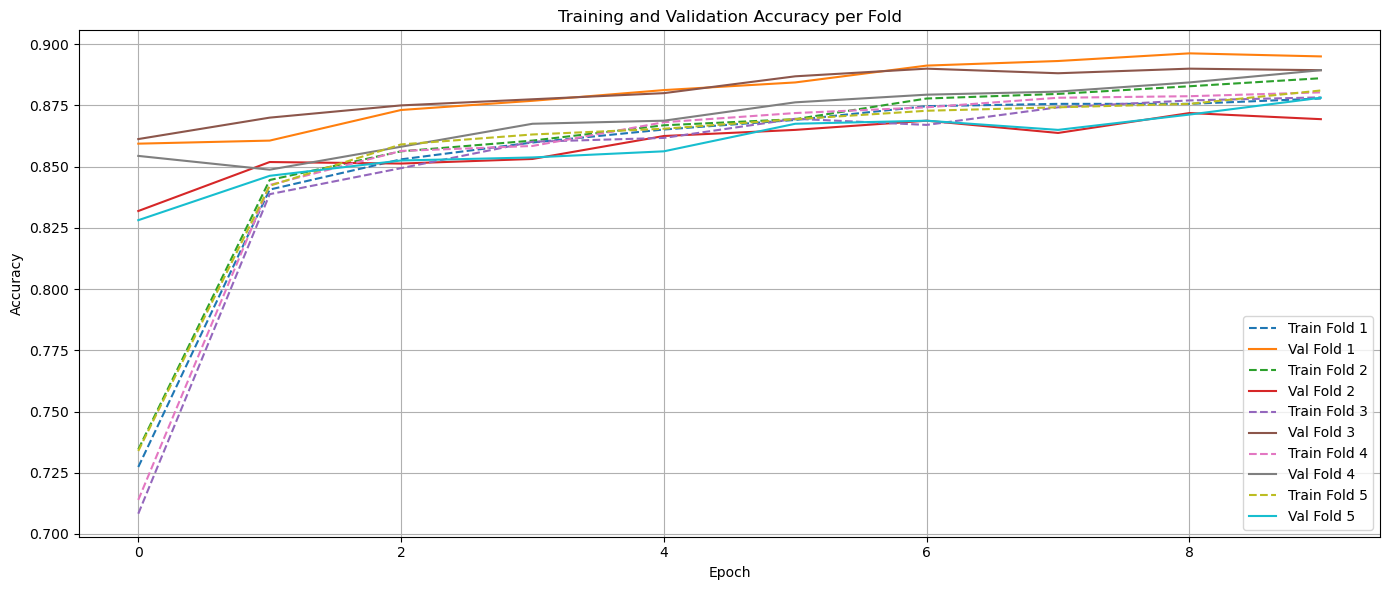

In [138]:
# ---- Plotting Loss Curves ----
plt.figure(figsize=(14, 6))
for i in range(k):
    plt.plot(train_losses_per_epoch[i], label=f"Train Fold {i+1}", linestyle='--')
    plt.plot(val_losses_per_epoch[i], label=f"Val Fold {i+1}")
plt.title("Training and Validation Loss per Fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plotting Accuracy Curves ----
plt.figure(figsize=(14, 6))
for i in range(k):
    plt.plot(train_accs_per_epoch[i], label=f"Train Fold {i+1}", linestyle='--')
    plt.plot(val_accs_per_epoch[i], label=f"Val Fold {i+1}")
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_52033/3214356372.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_

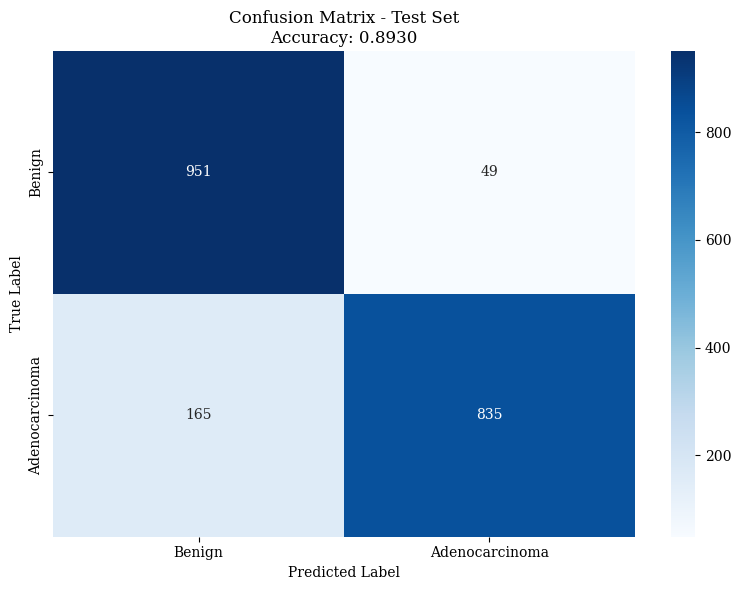


Test Accuracy: 0.8930 (89.30%)

Classification Report:
                precision    recall  f1-score   support

        Benign       0.85      0.95      0.90      1000
Adenocarcinoma       0.94      0.83      0.89      1000

      accuracy                           0.89      2000
     macro avg       0.90      0.89      0.89      2000
  weighted avg       0.90      0.89      0.89      2000



In [56]:
# Create test dataset using held-out test paths and labels
test_dataset = ScatteringDataset(test_paths, test_labels, scattering, transform=transform, device=device)

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load best model
best_model = ScatNetClassifier(input_dim=81).to(device)
best_model.load_state_dict(torch.load("best_scatnet_model.pth", map_location=device))
best_model.eval()

# Initialize lists for predictions and true labels
test_predictions = []
test_true_labels = []

# Run inference on test set
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Average pooling over spatial dims
        X_batch = X_batch.mean(dim=(-1, -2))  # [batch_size, 81]

        outputs = best_model(X_batch)
        predictions = outputs.argmax(dim=1)

        test_predictions.extend(predictions.cpu().numpy().flatten())
        test_true_labels.extend(y_batch.cpu().numpy().flatten())

# Convert to NumPy arrays
test_predictions = np.array(test_predictions).flatten()
test_true_labels = np.array(test_true_labels).flatten()

# Compute confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Adenocarcinoma'],
            yticklabels=['Benign', 'Adenocarcinoma'])
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print accuracy and classification report
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=['Benign', 'Adenocarcinoma']))


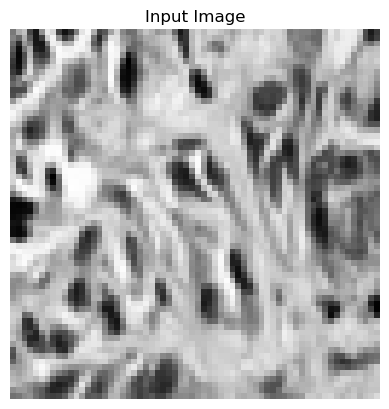

Scattering output shape: torch.Size([1, 1, 81, 16, 16])


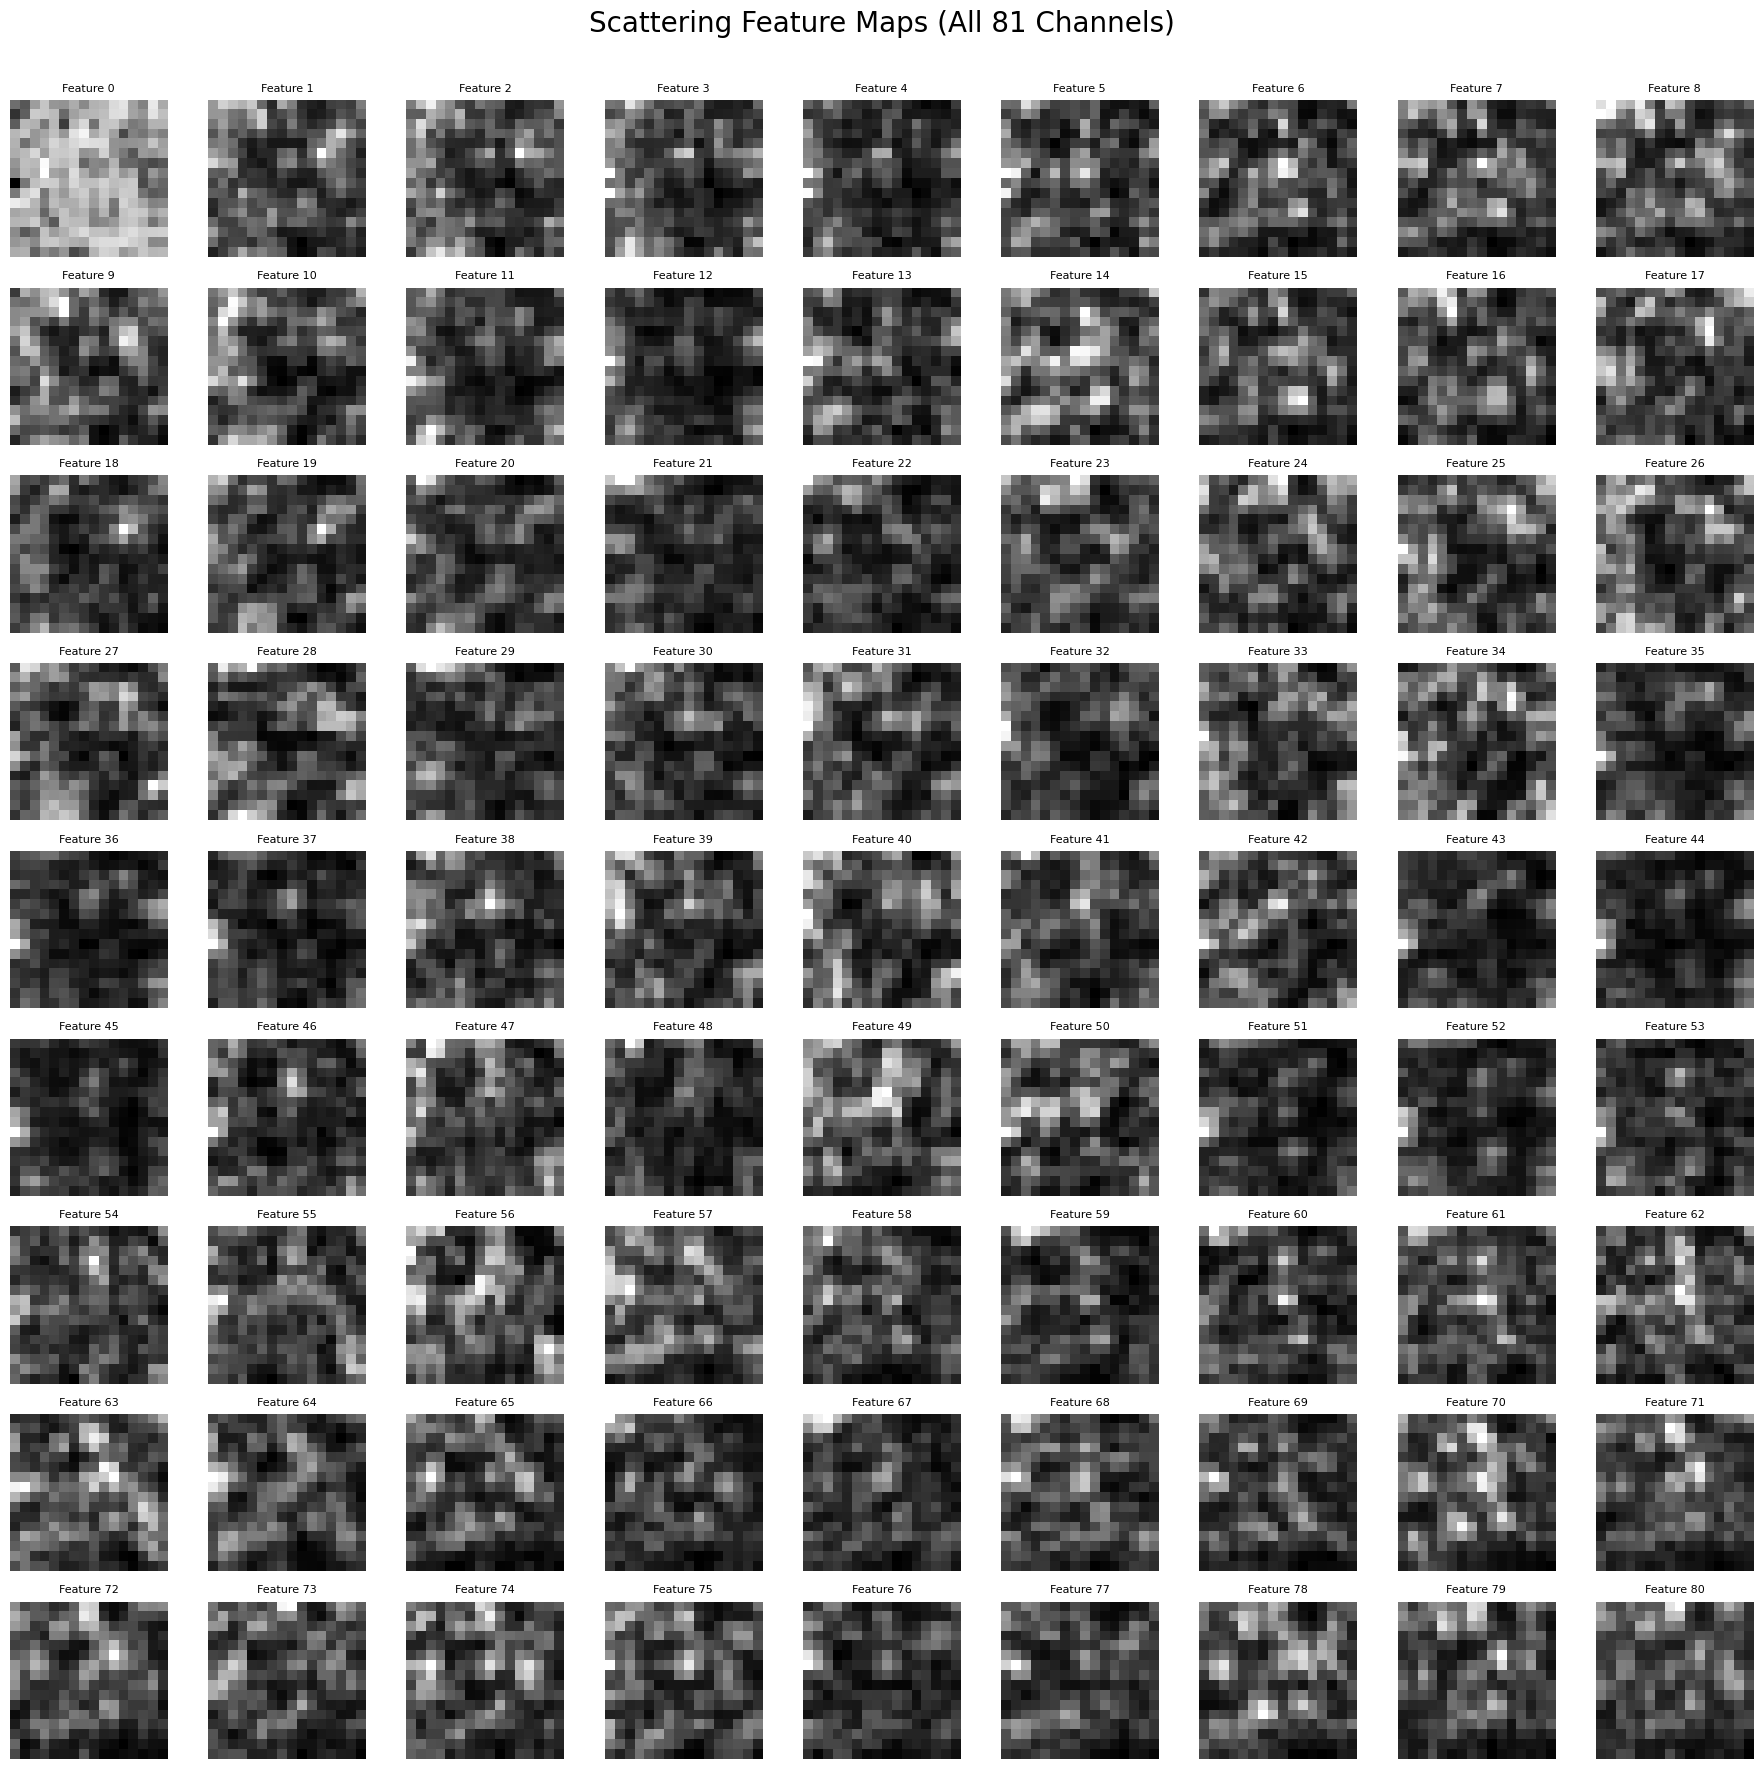

In [11]:
# ----- Step 1: Load a grayscale image -----
img_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma/0001.jpg"  # Replace with your own image
img = Image.open(img_path).convert('L')  # Convert to grayscale
img = img.resize((64, 64))               # Resize to (64, 64)

# Visualize original image
plt.imshow(img, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

# ----- Step 2: Prepare image tensor -----
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to shape [1, H, W], range [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])
x = transform(img).unsqueeze(0)          # Add batch dimension → [1, 1, 64, 64]

# ----- Step 3: Define Scattering Transform -----
J = 2
L = 8
scattering = Scattering2D(J=J, shape=(64, 64), L=L)
x = x.to(torch.float32)                 # Make sure dtype is float32
Sx = scattering(x)                      # Output: [1, C, 16, 16]
print("Scattering output shape:", Sx.shape)

Sx_np = Sx.squeeze().cpu().numpy()  # shape: (81, 16, 16)

# Create a grid of 9 rows × 9 columns = 81 channels
fig, axs = plt.subplots(9, 9, figsize=(18, 18))
fig.suptitle("Scattering Feature Maps (All 81 Channels)", fontsize=20)

for i in range(81):
    ax = axs[i // 9, i % 9]
    ax.imshow(Sx_np[i], cmap='gray')
    ax.set_title(f"Feature {i}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Leave space for title
plt.show()


In [67]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Load model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ScatNetClassifier(input_dim=81).to(device)
model.load_state_dict(torch.load("best_scatnet_model.pth", map_location=device))
model.eval()

# Get one sample and move it to device
X_sample, y_sample = scattering_dataset[0]
X_sample = X_sample.unsqueeze(0).mean(dim=(-1, -2)).to(device)  #global average pooling..> shape: [1, 81]
X_sample.requires_grad_(True)

# Attribution method (Integrated Gradients:measures how much each feature contributes to the prediction )
ig = IntegratedGradients(model)
attr = ig.attribute(X_sample, target=y_sample)
baseline = torch.zeros_like(X_sample).to(device)


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_48119/1976561597.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_scatne

In [68]:
X_sample.requires_grad_(True)


tensor([[0.3603, 0.0204, 0.0183, 0.0170, 0.0165, 0.0178, 0.0199, 0.0215, 0.0213,
         0.0328, 0.0301, 0.0276, 0.0291, 0.0295, 0.0328, 0.0357, 0.0355, 0.0040,
         0.0032, 0.0028, 0.0024, 0.0023, 0.0026, 0.0030, 0.0037, 0.0033, 0.0032,
         0.0030, 0.0025, 0.0022, 0.0022, 0.0024, 0.0030, 0.0025, 0.0026, 0.0029,
         0.0027, 0.0024, 0.0020, 0.0021, 0.0024, 0.0019, 0.0019, 0.0023, 0.0028,
         0.0027, 0.0023, 0.0020, 0.0020, 0.0018, 0.0017, 0.0022, 0.0030, 0.0034,
         0.0033, 0.0026, 0.0023, 0.0022, 0.0019, 0.0022, 0.0027, 0.0034, 0.0041,
         0.0037, 0.0031, 0.0029, 0.0023, 0.0023, 0.0026, 0.0030, 0.0038, 0.0045,
         0.0038, 0.0034, 0.0027, 0.0026, 0.0025, 0.0026, 0.0032, 0.0037, 0.0039]],
       device='mps:0', requires_grad=True)

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ScatNetClassifier().to(device)
model.load_state_dict(torch.load("best_scatnet_model.pth", map_location=device))
model.eval()  # set model to evaluation mode

# Get one sample from dataset and apply global mean pooling
X_sample, y_sample = scattering_dataset[0]  # [81, 16, 16]
X_sample = X_sample.unsqueeze(0).mean(dim=(-1, -2)).to(device)  # → [1, 81]

# Prepare input for masking
x = X_sample.clone().detach()  
x_flat = x.view(-1)  # flatten to [81]

# Define baseline: all zeros (represents "no feature information")
baseline_flat = torch.zeros_like(x_flat)
num_features = x_flat.shape[0]  # total number of features = 81

# -------------------------------
# 2. Define prediction function
# -------------------------------

# Choose the class to explain (e.g., class 0 = benign, class 1 = adenocarcinoma)
target_class = y_sample  

# Model wrapper to return probability for target class
def f(input_tensor):
    with torch.no_grad():  # no need to compute gradients
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)  # convert logits to probabilities
        return probs[:, target_class]  # extract prob for class of interest





/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_52033/490270749.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_scatnet

100%|██████████| 200/200 [00:19<00:00, 10.51it/s]


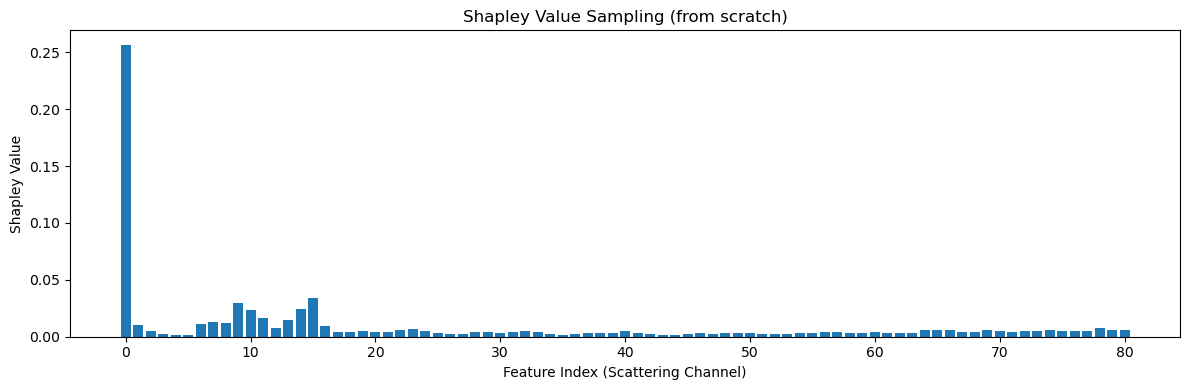

In [76]:
# -------------------------------
# 3. Shapley Value Sampling
# -------------------------------

M = 200  # number of random permutations (Monte Carlo samples)
shap_values = torch.zeros(num_features, device=device)  # accumulate SHAP values here(81 zeros)

# For each permutation
for _ in tqdm(range(M)):
    perm = torch.randperm(num_features, device=device)  # random feature order
    current_mask = torch.zeros(num_features, device=device)  # start with all features OFF

    # Compute model output with no features included (only baseline)
    prev_out = f((current_mask * x_flat + (1 - current_mask) * baseline_flat).unsqueeze(0))

    # Incrementally turn on features based on the permutation
    for i in perm:
        current_mask[i] = 1  # activate feature i
        masked_input = (current_mask * x_flat + (1 - current_mask) * baseline_flat).unsqueeze(0)
        new_out = f(masked_input)  # get model output with feature i turned on

        # Compute marginal contribution of feature i in this permutation
        shap_values[i] += (new_out - prev_out).item()

        # Update previous output for next step
        prev_out = new_out

# Average contributions over all M permutations → final SHAP values
shap_values /= M

# -------------------------------
# 4. Visualize Shapley values
# -------------------------------

# Convert SHAP tensor to NumPy for plotting
shap_np = shap_values.detach().cpu().numpy() #to get the shap values only (81,)

# Plot bar chart of SHAP values
plt.figure(figsize=(12, 4))
plt.bar(np.arange(num_features), shap_np)
plt.xlabel("Feature Index (Scattering Channel)")
plt.ylabel("Shapley Value")
plt.title("Shapley Value Sampling (from scratch)")
plt.tight_layout()
plt.show()

# Save SHAP values to .npy file (optional)
np.save("shapley_sampling.npy", shap_np)

/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_52033/3787933994.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_scatn

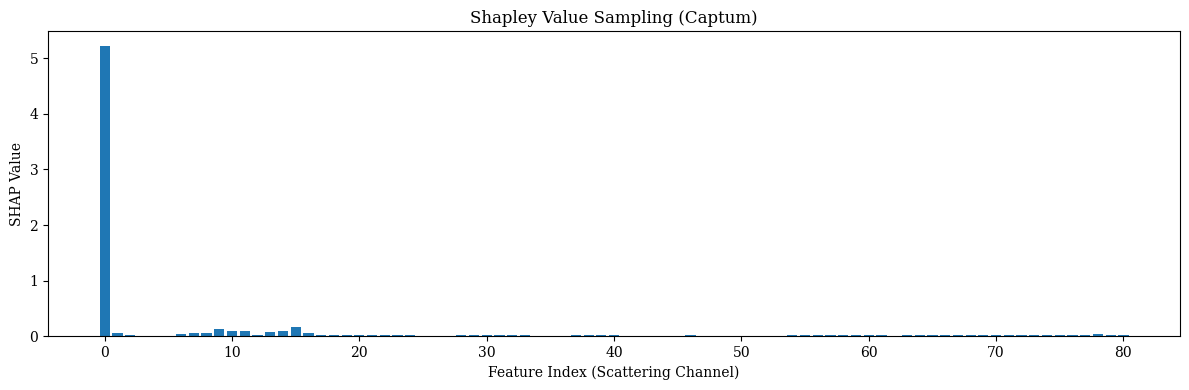

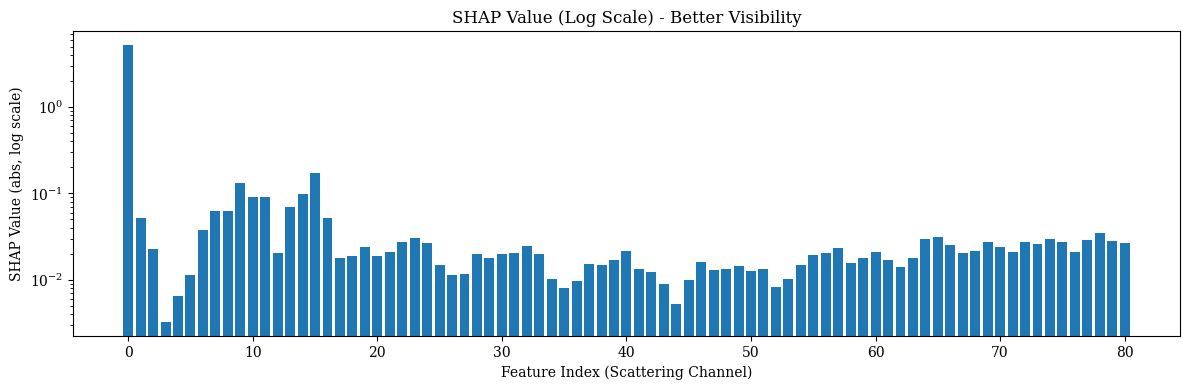

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import ShapleyValueSampling


# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load trained model
model = ScatNetClassifier().to(device)
model.load_state_dict(torch.load("best_scatnet_model.pth", map_location=device))
model.eval()

# --------------------------------------
# 1. Prepare input sample
# --------------------------------------
X_sample, y_sample = scattering_dataset[0]  # e.g., [81, 16, 16], label ∈ {0,1}
X_sample = X_sample.unsqueeze(0).mean(dim=(-1, -2)).to(device)  # → [1, 81]
X_sample.requires_grad_(True)

# --------------------------------------
# 2. Apply Shapley Value Sampling
# --------------------------------------
shap = ShapleyValueSampling(model)
attributions = shap.attribute(inputs=X_sample, target=y_sample)

shap_np = attributions.detach().cpu().numpy().flatten()

# --------------------------------------
# 3. Plot SHAP (standard)
# --------------------------------------
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(shap_np)), shap_np)
plt.xlabel("Feature Index (Scattering Channel)")
plt.ylabel("SHAP Value")
plt.title("Shapley Value Sampling (Captum)")
plt.tight_layout()
plt.show()

# --------------------------------------
# 4. Log Scale SHAP Plot
# --------------------------------------
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(shap_np)), np.abs(shap_np))
plt.yscale('log')
plt.xlabel("Feature Index (Scattering Channel)")
plt.ylabel("SHAP Value (abs, log scale)")
plt.title("SHAP Value (Log Scale) - Better Visibility")
plt.tight_layout()
plt.show()


np.save("captum_shapley_values.npy", shap_np)


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_1674/1880308794.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_mod

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.05s/it]               


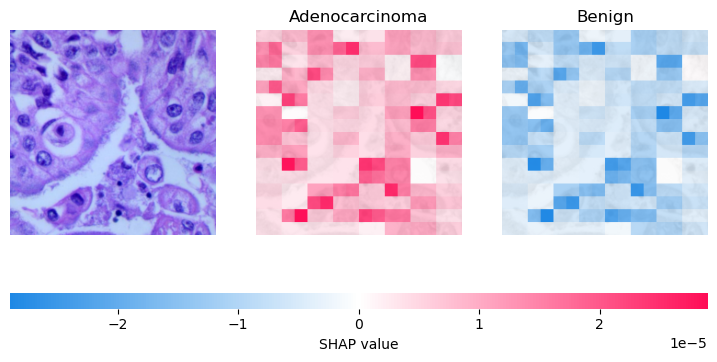

In [50]:
# Load your trained model
model = ImprovedCNN()
model.load_state_dict(torch.load("best_cnn_model.pth", map_location="cpu"))
model.eval()  # Set to evaluation mode (no dropout, no batch norm updates)

# Define the two class names used in your binary classifier
class_names = ["Benign", "Adenocarcinoma"]

# Define the image preprocessing pipeline (must match your training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalized to [-1, 1]
])

# Helper function to reverse normalization for visualization
unnormalize = lambda x: x * 0.5 + 0.5

# Load one random image from the adenocarcinoma folder
image_dir = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
img_path = os.path.join(image_dir, random.choice(image_files))

# Open the image, apply the transform, and add batch dimension
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # Shape: [1, 3, 224, 224]

# Convert to numpy format and unnormalize to [0, 1] for SHAP visualization
X = unnormalize(img_tensor).numpy().transpose(0, 2, 3, 1)  # Shape: [1, 224, 224, 3]

# Define the prediction function for SHAP (returns softmax probabilities)
def f(x):
    x_tensor = torch.tensor(x.transpose(0, 3, 1, 2)).float()  # Convert NHWC to NCHW
    with torch.no_grad():
        return F.softmax(model(x_tensor), dim=1).numpy()

# Create the image masker using small blur patches (higher detail)
masker_blur = shap.maskers.Image("blur(32,32)", X[0].shape)

# Create the SHAP explainer using the prediction function and masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# Compute SHAP values for the top 2 predicted classes
# max_evals controls explanation granularity
# batch_size controls speed (batches of masked images sent to model)
shap_values_fine = explainer_blur(
    X, 
    max_evals=5000, 
    batch_size=30, 
    outputs=shap.Explanation.argsort.flip[:2]  # Top 2 classes for this image
)

# Visualize the SHAP explanation
# The plot will show original image and SHAP overlays for each class
shap.image_plot(shap_values_fine, pixel_values=X)


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_52033/2847933435.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_mo

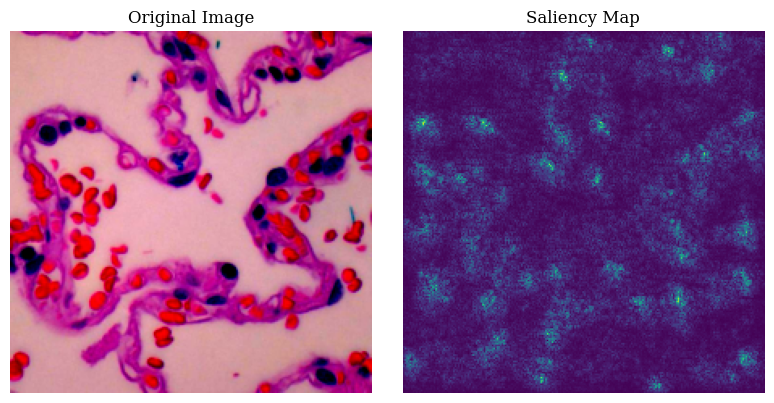

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


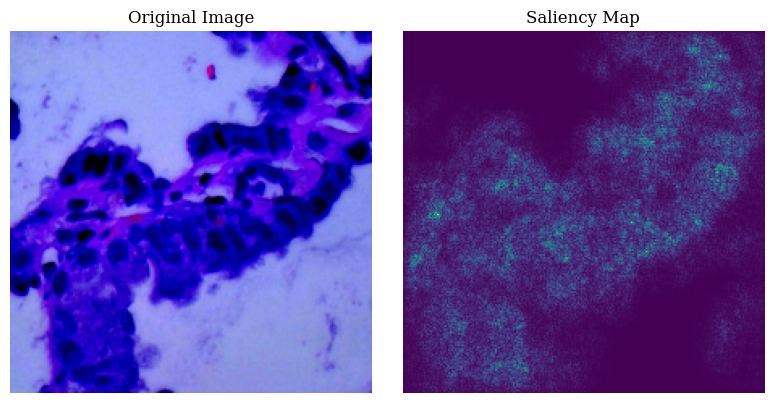

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


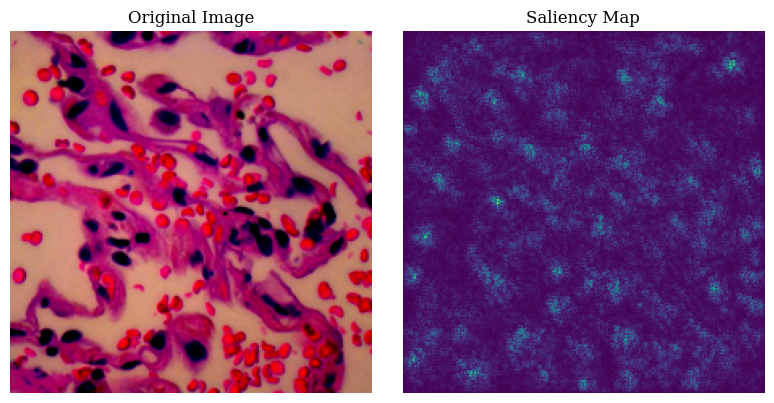

In [51]:
from captum.attr import Saliency

# Load model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("best_cnn_model.pth", map_location=device))
model.eval()

# Initialize Saliency explainer
saliency = Saliency(model)

# Loop over 3 test samples
for idx in range(3):
    # Load image and label
    image, label = test_dataset[idx]  # shape: [3, 64, 64]
    input_tensor = image.unsqueeze(0).to(device).requires_grad_(True)  # [1, 3, 64, 64]

    # Compute saliency attributions
    attributions = saliency.attribute(input_tensor, target=label)
    saliency_map = attributions.squeeze().abs().detach().cpu().numpy()  # [3, 64, 64]

    # Convert original image to numpy
    original_np = image.permute(1, 2, 0).cpu().numpy()  # [64, 64, 3]

    # Collapse to 2D for visualization
    saliency_map = saliency_map.max(axis=0)  # shape: [64, 64]

    # Plot original and saliency
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(saliency_map, cmap='viridis')
    axs[1].set_title("Saliency Map")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_52033/1320803792.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_mo

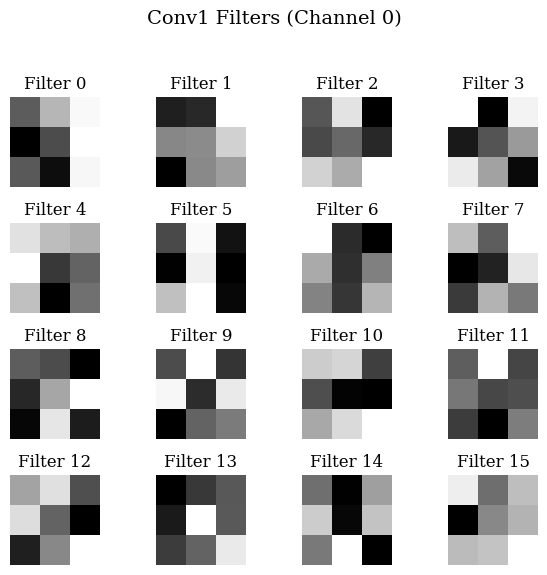

In [54]:
# Load model and weights
model = ImprovedCNN()
model.load_state_dict(torch.load("best_cnn_model.pth", map_location="cpu"))
model.eval()

# Get conv1 filters: shape = [16 filters, 3 channels, 3, 3]
filters = model.conv1.weight.data.cpu().numpy()

# Select only one channel (e.g., channel 0 = red)
channel_idx = 0

# Plot only the selected channel of each filter
fig, axs = plt.subplots(4, 4, figsize=(6, 6))  # 16 filters in a 4x4 grid
axs = axs.flatten()

for i in range(16):
    axs[i].imshow(filters[i, channel_idx], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Filter {i}')

plt.suptitle(f"Conv1 Filters (Channel {channel_idx})", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


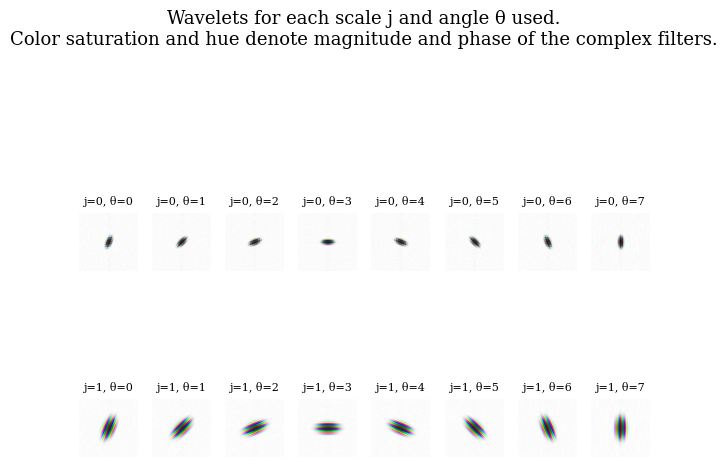

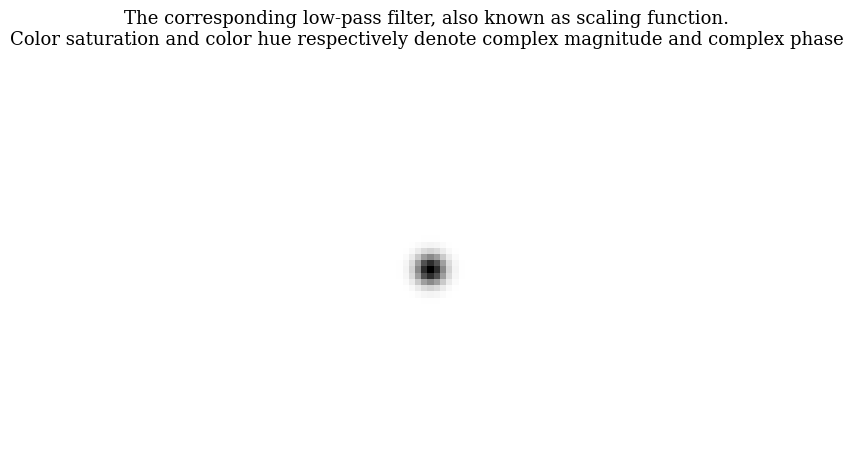

In [55]:
from numpy.fft import fft2
from kymatio.scattering2d.filter_bank import filter_bank
from colorsys import hls_to_rgb

# -------- Custom colorize function --------
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2 * np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 / (1.0 + abs(z[idx]) ** 0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

# -------- Filter Parameters --------
M = 64
J = 2
L = 8

filters_set = filter_bank(M, M, J, L=L)

# -------- Plot wavelet filters --------
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('font', family='serif')

i = 0
for filt in filters_set['psi']:
    f = filt["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(f"j={i // L}, θ={i % L}", fontsize=8)
    i += 1

fig.suptitle((
    "Wavelets for each scale j and angle θ used.\n"
    "Color saturation and hue denote magnitude and phase of the complex filters."
), fontsize=13)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi']["levels"][0]

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
plt.suptitle(("The corresponding low-pass filter, also known as scaling "
              "function.\nColor saturation and color hue respectively denote "
              "complex magnitude and complex phase"), fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

plt.tight_layout()
plt.show()
